The code to generate the quantum federated datasets

## Setup

Install TensorFlow Federated

Install TensorFlow 

Install TensorFlow Quantum:

Import the required modules and their dependencies

In [1]:
import nest_asyncio
nest_asyncio.apply()
#The next library is necessary to import the federated data
import h5py
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_quantum as tfq
import cirq
import sympy
import scipy
tf.compat.v1.enable_v2_behavior()
np.random.seed(0)

root_path = "./Datasets/"

2025-02-09 11:11:04.121600: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-02-09 11:11:04.121671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-09 11:11:13.099218: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-02-09 11:11:15.026417: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-09 11:11:15.026501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.035GHz coreCount: 20 devi

# Generating the quantum data
The input data is defined as excitations to the cluster state, represented by rotations along the x-axis on the Bloch sphere. A large enough rotation is deemed an excitation and is labeled `1` and a rotation that isn't large enough is labeled `0` and deemed not an excitation.

A single client dataset

Note: you may need to restart the kernel to use updated packages.


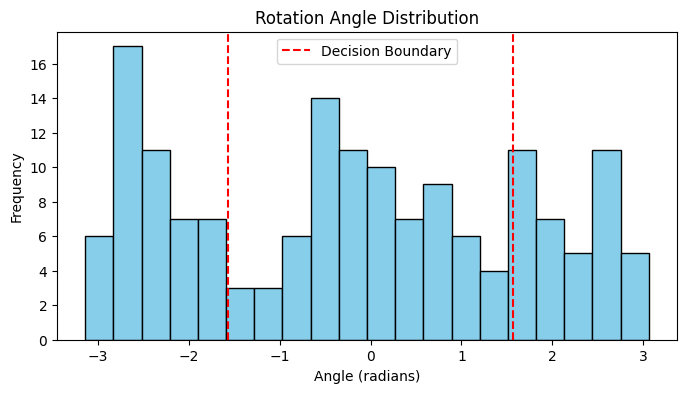

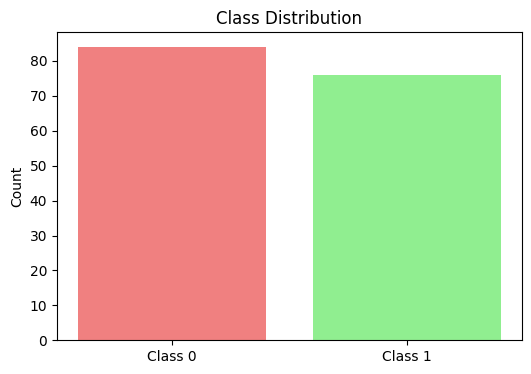

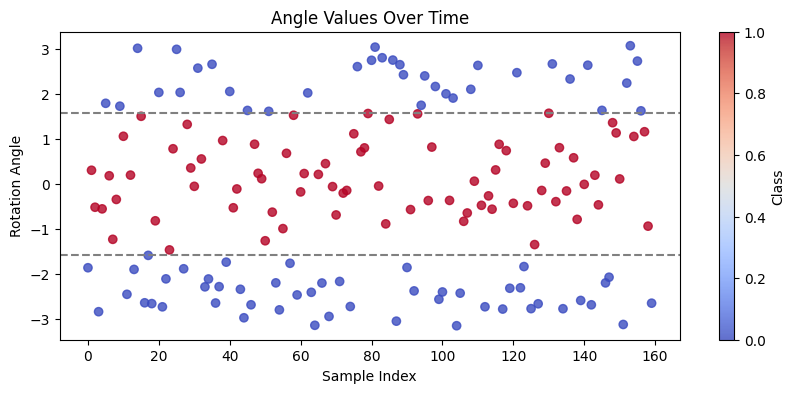

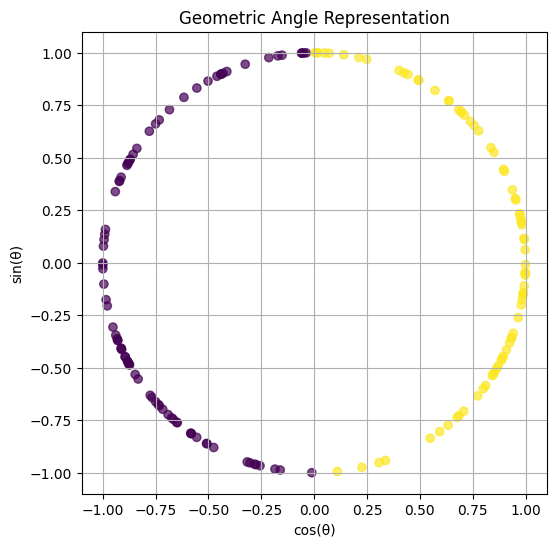

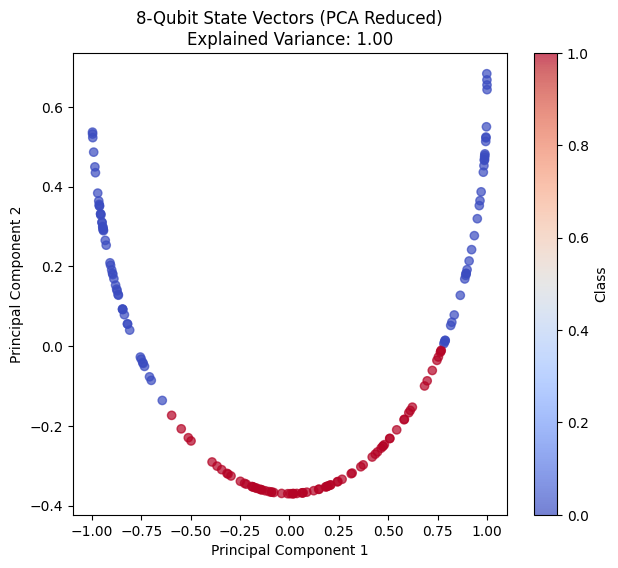

In [52]:
%pip install scikit-learn

import cirq
import tensorflow_quantum as tfq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

def generate_quantum_data(n_qubits=2, n_rounds=20):
    """Generate quantum data with state vectors."""
    qubits = cirq.GridQubit.rect(1, n_qubits)
    labels = []
    angles = []
    states = []
    simulator = cirq.Simulator()

    for _ in range(n_rounds):
        for qubit in qubits:
            angle = np.random.uniform(-np.pi, np.pi)
            circuit = cirq.Circuit(cirq.rx(angle)(qubit))
            
            # Simulate to get state vector
            result = simulator.simulate(circuit)
            state = result.final_state_vector
            
            states.append(state)
            labels.append(1 if -np.pi/2 <= angle <= np.pi/2 else 0)
            angles.append(angle)
    
    return np.array(states), np.array(labels), np.array(angles)

def visualize_quantum_data(n_qubits=8, n_rounds=20):
    """Generate separate visualizations for quantum data analysis."""
    states, labels, angles = generate_quantum_data(n_qubits, n_rounds)
    
    # 1. Angle Distribution
    plt.figure(figsize=(8, 4))
    plt.hist(angles, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(-np.pi/2, color='red', linestyle='--', label='Decision Boundary')
    plt.axvline(np.pi/2, color='red', linestyle='--')
    plt.title("Rotation Angle Distribution")
    plt.xlabel("Angle (radians)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 2. Class Distribution
    plt.figure(figsize=(6, 4))
    plt.bar(['Class 0', 'Class 1'], 
            [np.sum(labels == 0), np.sum(labels == 1)],
            color=['lightcoral', 'lightgreen'])
    plt.title("Class Distribution")
    plt.ylabel("Count")
    plt.show()

    # 3. Temporal Angle Pattern
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(angles)), angles, c=labels, cmap='coolwarm', alpha=0.8)
    plt.axhline(np.pi/2, color='gray', linestyle='--')
    plt.axhline(-np.pi/2, color='gray', linestyle='--')
    plt.title("Angle Values Over Time")
    plt.xlabel("Sample Index")
    plt.ylabel("Rotation Angle")
    plt.colorbar(label='Class')
    plt.show()

    # 4. Geometric Representation
    plt.figure(figsize=(6, 6))
    plt.scatter(np.cos(angles), np.sin(angles), c=labels, cmap='viridis', alpha=0.7)
    plt.title("Geometric Angle Representation")
    plt.xlabel("cos(θ)")
    plt.ylabel("sin(θ)")
    plt.grid(True)
    plt.show()

    # 5. Quantum State Visualization (PCA)
    # Convert complex states to real vectors
    real_states = np.hstack([np.real(states), np.imag(states)])
    
    # Apply PCA
    pca = PCA(n_components=2)
    reduced_states = pca.fit_transform(real_states)
    
    plt.figure(figsize=(7, 6))
    plt.scatter(reduced_states[:, 0], reduced_states[:, 1], 
                c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(f"8-Qubit State Vectors (PCA Reduced)\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label='Class')
    plt.show()

# Generate and display visualizations
visualize_quantum_data(n_qubits=8, n_rounds=20)

In [3]:
# Look at some data samples
sample_points, sample_labels = generate_data(cirq.GridQubit.rect(1, 8))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(0.098π)─── Output: 1
Input: (0, 1): ───Rx(0.43π)─── Output: 1


In [4]:
# Check the type of the decoded data (string)
print(type(sample_points[0].numpy().decode('utf-8','ignore')))

<class 'str'>


# Generating the quantum federated datasets


## 24 Clients, 160 sample

In [5]:
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_1, sample_labels_1 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_2, sample_labels_2 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_3, sample_labels_3 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_4, sample_labels_4 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_5, sample_labels_5 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_6, sample_labels_6 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_7, sample_labels_7 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_8, sample_labels_8 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_9, sample_labels_9 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_10, sample_labels_10 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_11, sample_labels_11 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_12, sample_labels_12 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_13, sample_labels_13 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_14, sample_labels_14 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_15, sample_labels_15 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_16, sample_labels_16 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_17, sample_labels_17 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_18, sample_labels_18 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_19, sample_labels_19 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_20, sample_labels_20 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_21, sample_labels_21 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_22, sample_labels_22 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_23, sample_labels_23 = generate_data(cirq.GridQubit.rect(1, 8))

In [6]:
sample_points0 = []
sample_labels0 = []
sample_points1 = []
sample_labels1 = []
sample_points2 = []
sample_labels2 = []
sample_points3 = []
sample_labels3 = []
sample_points4 = []
sample_labels4 = []
sample_points5 = []
sample_labels5 = []
sample_points6 = []
sample_labels6 = []
sample_points7 = []
sample_labels7 = []
sample_points8 = []
sample_labels8 = []
sample_points9 = []
sample_labels9 = []
sample_points10 = []
sample_labels10 = []
sample_points11 = []
sample_labels11 = []
sample_points12 = []
sample_labels12 = []
sample_points13 = []
sample_labels13 = []
sample_points14 = []
sample_labels14 = []
sample_points15 = []
sample_labels15 = []
sample_points16 = []
sample_labels16 = []
sample_points17 = []
sample_labels17 = []
sample_points18 = []
sample_labels18 = []
sample_points19 = []
sample_labels19 = []
sample_points20 = []
sample_labels20 = []
sample_points21 = []
sample_labels21 = []
sample_points22 = []
sample_labels22 = []
sample_points23 = []
sample_labels23 = []

In [7]:
for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))

for i in range(len(sample_points_0)):
  sample_points1.append((sample_points_1[i].numpy()))
  sample_labels1.append((sample_labels_1[i]))

for i in range(len(sample_points_0)):
  sample_points2.append((sample_points_2[i].numpy()))
  sample_labels2.append((sample_labels_2[i]))

for i in range(len(sample_points_0)):
  sample_points3.append((sample_points_3[i].numpy()))
  sample_labels3.append((sample_labels_3[i]))

for i in range(len(sample_points_0)):
  sample_points4.append((sample_points_4[i].numpy()))
  sample_labels4.append((sample_labels_4[i]))

for i in range(len(sample_points_0)):
  sample_points5.append((sample_points_5[i].numpy()))
  sample_labels5.append((sample_labels_5[i]))

for i in range(len(sample_points_0)):
  sample_points6.append((sample_points_6[i].numpy()))
  sample_labels6.append((sample_labels_6[i]))

for i in range(len(sample_points_0)):
  sample_points7.append((sample_points_7[i].numpy()))
  sample_labels7.append((sample_labels_7[i]))

for i in range(len(sample_points_0)):
  sample_points8.append((sample_points_8[i].numpy()))
  sample_labels8.append((sample_labels_8[i]))

for i in range(len(sample_points_0)):
  sample_points9.append((sample_points_9[i].numpy()))
  sample_labels9.append((sample_labels_9[i]))

for i in range(len(sample_points_0)):
  sample_points10.append((sample_points_10[i].numpy()))
  sample_labels10.append((sample_labels_10[i]))

for i in range(len(sample_points_0)):
  sample_points11.append((sample_points_11[i].numpy()))
  sample_labels11.append((sample_labels_11[i]))


for i in range(len(sample_points_0)):
  sample_points12.append((sample_points_12[i].numpy()))
  sample_labels12.append((sample_labels_12[i]))

for i in range(len(sample_points_0)):
  sample_points13.append((sample_points_13[i].numpy()))
  sample_labels13.append((sample_labels_13[i]))

for i in range(len(sample_points_0)):
  sample_points14.append((sample_points_14[i].numpy()))
  sample_labels14.append((sample_labels_14[i]))

for i in range(len(sample_points_0)):
  sample_points15.append((sample_points_15[i].numpy()))
  sample_labels15.append((sample_labels_15[i]))    

for i in range(len(sample_points_0)):
  sample_points16.append((sample_points_16[i].numpy()))
  sample_labels16.append((sample_labels_16[i]))    

for i in range(len(sample_points_0)):
  sample_points17.append((sample_points_17[i].numpy()))
  sample_labels17.append((sample_labels_17[i]))    

for i in range(len(sample_points_0)):
  sample_points18.append((sample_points_18[i].numpy()))
  sample_labels18.append((sample_labels_18[i]))    

for i in range(len(sample_points_0)):
  sample_points19.append((sample_points_19[i].numpy()))
  sample_labels19.append((sample_labels_19[i]))    

for i in range(len(sample_points_0)):
  sample_points20.append((sample_points_20[i].numpy()))
  sample_labels20.append((sample_labels_20[i]))    

for i in range(len(sample_points_0)):
  sample_points21.append((sample_points_21[i].numpy()))
  sample_labels21.append((sample_labels_21[i]))    

for i in range(len(sample_points_0)):
  sample_points22.append((sample_points_22[i].numpy()))
  sample_labels22.append((sample_labels_22[i]))    

for i in range(len(sample_points_0)):
  sample_points23.append((sample_points_23[i].numpy()))
  sample_labels23.append((sample_labels_23[i]))    



In [8]:
sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)
sample_points1 = np.array(sample_points1)
sample_labels1 = np.array(sample_labels1)
sample_points2 = np.array(sample_points2)
sample_labels2 = np.array(sample_labels2)
sample_points3 = np.array(sample_points3)
sample_labels3 = np.array(sample_labels3)
sample_points4 = np.array(sample_points4)
sample_labels4 = np.array(sample_labels4)
sample_points5 = np.array(sample_points5)
sample_labels5 = np.array(sample_labels5)
sample_points6 = np.array(sample_points6)
sample_labels6 = np.array(sample_labels6)
sample_points7 = np.array(sample_points7)
sample_labels7 = np.array(sample_labels7)
sample_points8 = np.array(sample_points8)
sample_labels8 = np.array(sample_labels8)
sample_points9 = np.array(sample_points9)
sample_labels9 = np.array(sample_labels9)
sample_points10 = np.array(sample_points10)
sample_labels10 = np.array(sample_labels10)
sample_points11 = np.array(sample_points11)
sample_labels11 = np.array(sample_labels11)
sample_points12 = np.array(sample_points12)
sample_labels12 = np.array(sample_labels12)
sample_points13 = np.array(sample_points13)
sample_labels13 = np.array(sample_labels13)
sample_points14 = np.array(sample_points14)
sample_labels14 = np.array(sample_labels14)
sample_points15 = np.array(sample_points15)
sample_labels15 = np.array(sample_labels15)
sample_points16 = np.array(sample_points16)
sample_labels16 = np.array(sample_labels16)
sample_points17 = np.array(sample_points17)
sample_labels17 = np.array(sample_labels17)
sample_points18 = np.array(sample_points18)
sample_labels18 = np.array(sample_labels18)
sample_points19 = np.array(sample_points19)
sample_labels19 = np.array(sample_labels19)
sample_points20 = np.array(sample_points20)
sample_labels20 = np.array(sample_labels20)
sample_points21 = np.array(sample_points21)
sample_labels21 = np.array(sample_labels21)
sample_points22 = np.array(sample_points22)
sample_labels22 = np.array(sample_labels22)
sample_points23 = np.array(sample_points23)
sample_labels23 = np.array(sample_labels23)

## Changing the number of clients
Just add more lines

### generate 30 clients, 160 sample

In [5]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))

#sample_points_30, sample_labels_30 = generate_data(cirq.GridQubit.rect(1, 8))

In [6]:
#@title
sample_points0 = []
sample_labels0=[]
#sample_points30 = []
#sample_labels30 = []

for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))
  

#for i in range(len(sample_points_0)):
#  sample_points30.append((sample_points_30[i].numpy()))
#  sample_labels30.append((sample_labels_30[i]))    


sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)

#sample_points30 = np.array(sample_points30)
#sample_labels30 = np.array(sample_labels30)
                                                   

In [7]:
#@title
with h5py.File(root_path + '1clients_160_noniid.hdf5', 'w') as f:
    f.create_group('/examples/c0')

    #f.create_group('/examples/c30')
    group0 = f['/examples']['c0']

    #group30 = f['/examples']['c30']                       
    group0.create_dataset('x', shape=[160,1], data=sample_points0)

    #group30.create_dataset('circuit', shape=[160,1],data=sample_points30)
    
    group0.create_dataset('y', shape=[160,1],data=sample_labels0)

    #group30.create_dataset('y', shape=[160,1], data=sample_labels30)

    

### generate 30 clients 96 sample

In [11]:
#@title
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 12  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    #split_ind = int(len(excitations) * 0.7)
    #train_excitations = excitations[:split_ind]
    #test_excitations = excitations[split_ind:]

    #train_labels = labels[:split_ind]
    #test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(excitations), np.array(labels)
    #tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
     #   tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [12]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))

#sample_points_30, sample_labels_30 = generate_data(cirq.GridQubit.rect(1, 8))

In [13]:
#@title
sample_points0 = []
sample_labels0 = []

#sample_points30 = []
#sample_labels30 = []

for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))
   

#for i in range(len(sample_points_0)):
#  sample_points30.append((sample_points_30[i].numpy()))
#  sample_labels30.append((sample_labels_30[i]))    


sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)

#sample_points30 = np.array(sample_points30)
#sample_labels30 = np.array(sample_labels30)
                                                   

In [14]:
#@title
with h5py.File(root_path + 'clients1_96sample.hdf5', 'w') as f:
    f.create_group('/examples/c0')

    #f.create_group('/examples/c30')
    group0 = f['/examples']['c0']

    #group30 = f['/examples']['c30']                       
    group0.create_dataset('x', shape=[96,1], data=sample_points0)

    #group30.create_dataset('circuit', shape=[96,1],data=sample_points30)
    
    group0.create_dataset('y', shape=[96,1],data=sample_labels0)

    #group30.create_dataset('y', shape=[96,1], data=sample_labels30)

    

### generate 30 clients 248 sample

In [15]:
#@title
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 31  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    #split_ind = int(len(excitations) * 0.7)
    #train_excitations = excitations[:split_ind]
    #test_excitations = excitations[split_ind:]

    #train_labels = labels[:split_ind]
    #test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(excitations), np.array(labels)
    #tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
     #   tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [16]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))

#sample_points_30, sample_labels_30 = generate_data(cirq.GridQubit.rect(1, 8))

In [17]:
#@title
sample_points0 = []
sample_labels0 = []

#sample_points30 = []
#sample_labels30 = []

for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))


#for i in range(len(sample_points_0)):
#  sample_points30.append((sample_points_30[i].numpy()))
#  sample_labels30.append((sample_labels_30[i]))    


sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)

#sample_points30 = np.array(sample_points30)
#sample_labels30 = np.array(sample_labels30)
                                                   

In [18]:
#@title
with h5py.File(root_path + 'clients1_248sample.hdf5', 'w') as f:
    f.create_group('/examples/c0')

    #f.create_group('/examples/c30')
    group0 = f['/examples']['c0']

    #group30 = f['/examples']['c30']                       
    group0.create_dataset('x', shape=[248,1], data=sample_points0)

    #group30.create_dataset('x', shape=[248,1],data=sample_points30)
    
    group0.create_dataset('y', shape=[248,1],data=sample_labels0)

    #group30.create_dataset('y', shape=[248,1], data=sample_labels30)

    

### generate 30 clients 400 sample

In [32]:
#@title
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 15  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    #split_ind = int(len(excitations) * 0.7)
    #train_excitations = excitations[:split_ind]
    #test_excitations = excitations[split_ind:]

    #train_labels = labels[:split_ind]
    #test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(excitations), np.array(labels)
    #tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
     #   tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [33]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))

#sample_points_30, sample_labels_30 = generate_data(cirq.GridQubit.rect(1, 8))

In [35]:
#@title
sample_points0 = []
sample_labels0 = []

#sample_points30 = []
#sample_labels30 = []

for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))
  

#for i in range(len(sample_points_0)):
#  sample_points30.append((sample_points_30[i].numpy()))
#  sample_labels30.append((sample_labels_30[i]))    


sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)

#sample_points30 = np.array(sample_points30)
#sample_labels30 = np.array(sample_labels30)
                                                   

In [36]:
#@title
with h5py.File(root_path + 'clients1_120sample.hdf5', 'w') as f:
    f.create_group('/examples/c0')

    #f.create_group('/examples/c30')
    group0 = f['/examples']['c0']

    #group30 = f['/examples']['c30']                       
    group0.create_dataset('x', shape=[120,1], data=sample_points0)

    #group30.create_dataset('x', shape=[400,1],data=sample_points30)
    
    group0.create_dataset('y', shape=[120,1],data=sample_labels0)

    #group30.create_dataset('label', shape=[400,1], data=sample_labels30)

    

### generate 60 clients 160 sample

In [24]:
#@title
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    #split_ind = int(len(excitations) * 0.7)
    #train_excitations = excitations[:split_ind]
    #test_excitations = excitations[split_ind:]

    #train_labels = labels[:split_ind]
    #test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(excitations), np.array(labels)
    #tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
     #   tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [25]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_1, sample_labels_1 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_2, sample_labels_2 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_3, sample_labels_3 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_4, sample_labels_4 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_5, sample_labels_5 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_6, sample_labels_6 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_7, sample_labels_7 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_8, sample_labels_8 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_9, sample_labels_9 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_10, sample_labels_10 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_11, sample_labels_11 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_12, sample_labels_12 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_13, sample_labels_13 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_14, sample_labels_14 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_15, sample_labels_15 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_16, sample_labels_16 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_17, sample_labels_17 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_18, sample_labels_18 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_19, sample_labels_19 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_20, sample_labels_20 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_21, sample_labels_21 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_22, sample_labels_22 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_23, sample_labels_23 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_24, sample_labels_24 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_25, sample_labels_25 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_26, sample_labels_26 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_27, sample_labels_27 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_28, sample_labels_28 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_29, sample_labels_29 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_30, sample_labels_30 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_31, sample_labels_31 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_32, sample_labels_32 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_33, sample_labels_33 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_34, sample_labels_34 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_35, sample_labels_35 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_36, sample_labels_36 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_37, sample_labels_37 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_38, sample_labels_38 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_39, sample_labels_39 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_40, sample_labels_40 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_41, sample_labels_41 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_42, sample_labels_42 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_43, sample_labels_43 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_44, sample_labels_44 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_45, sample_labels_45 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_46, sample_labels_46 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_47, sample_labels_47 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_48, sample_labels_48 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_49, sample_labels_49 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_50, sample_labels_50 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_51, sample_labels_51 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_52, sample_labels_52 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_53, sample_labels_53 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_54, sample_labels_54 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_55, sample_labels_55 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_56, sample_labels_56 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_57, sample_labels_57 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_58, sample_labels_58 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_59, sample_labels_59 = generate_data(cirq.GridQubit.rect(1, 8))

In [26]:
#@title
sample_points0 = []
sample_labels0 = []
sample_points1 = []
sample_labels1 = []
sample_points2 = []
sample_labels2 = []
sample_points3 = []
sample_labels3 = []
sample_points4 = []
sample_labels4 = []
sample_points5 = []
sample_labels5 = []
sample_points6 = []
sample_labels6 = []
sample_points7 = []
sample_labels7 = []
sample_points8 = []
sample_labels8 = []
sample_points9 = []
sample_labels9 = []
sample_points10 = []
sample_labels10 = []
sample_points11 = []
sample_labels11 = []
sample_points12 = []
sample_labels12 = []
sample_points13 = []
sample_labels13 = []
sample_points14 = []
sample_labels14 = []
sample_points15 = []
sample_labels15 = []
sample_points16 = []
sample_labels16 = []
sample_points17 = []
sample_labels17 = []
sample_points18 = []
sample_labels18 = []
sample_points19 = []
sample_labels19 = []
sample_points20 = []
sample_labels20 = []
sample_points21 = []
sample_labels21 = []
sample_points22 = []
sample_labels22 = []
sample_points23 = []
sample_labels23 = []
sample_points24 = []
sample_labels24 = []
sample_points25 = []
sample_labels25 = []
sample_points26 = []
sample_labels26 = []
sample_points27 = []
sample_labels27 = []
sample_points28 = []
sample_labels28 = []
sample_points29 = []
sample_labels29 = []
sample_points30 = []
sample_labels30 = []
sample_points31 = []
sample_labels31 = []
sample_points32 = []
sample_labels32 = []
sample_points33 = []
sample_labels33 = []
sample_points34 = []
sample_labels34 = []
sample_points35 = []
sample_labels35 = []
sample_points36 = []
sample_labels36 = []
sample_points37 = []
sample_labels37 = []
sample_points38 = []
sample_labels38 = []
sample_points39 = []
sample_labels39 = []
sample_points40 = []
sample_labels40 = []
sample_points41 = []
sample_labels41 = []
sample_points42 = []
sample_labels42 = []
sample_points43 = []
sample_labels43 = []
sample_points44 = []
sample_labels44 = []
sample_points45 = []
sample_labels45 = []
sample_points46 = []
sample_labels46 = []
sample_points47 = []
sample_labels47 = []
sample_points48 = []
sample_labels48 = []
sample_points49 = []
sample_labels49 = []
sample_points50 = []
sample_labels50 = []
sample_points51 = []
sample_labels51 = []
sample_points52 = []
sample_labels52 = []
sample_points53 = []
sample_labels53 = []
sample_points54 = []
sample_labels54 = []
sample_points55 = []
sample_labels55 = []
sample_points56 = []
sample_labels56 = []
sample_points57 = []
sample_labels57 = []
sample_points58 = []
sample_labels58 = []
sample_points59 = []
sample_labels59 = []


for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))

for i in range(len(sample_points_0)):
  sample_points1.append((sample_points_1[i].numpy()))
  sample_labels1.append((sample_labels_1[i]))

for i in range(len(sample_points_0)):
  sample_points2.append((sample_points_2[i].numpy()))
  sample_labels2.append((sample_labels_2[i]))

for i in range(len(sample_points_0)):
  sample_points3.append((sample_points_3[i].numpy()))
  sample_labels3.append((sample_labels_3[i]))

for i in range(len(sample_points_0)):
  sample_points4.append((sample_points_4[i].numpy()))
  sample_labels4.append((sample_labels_4[i]))

for i in range(len(sample_points_0)):
  sample_points5.append((sample_points_5[i].numpy()))
  sample_labels5.append((sample_labels_5[i]))

for i in range(len(sample_points_0)):
  sample_points6.append((sample_points_6[i].numpy()))
  sample_labels6.append((sample_labels_6[i]))

for i in range(len(sample_points_0)):
  sample_points7.append((sample_points_7[i].numpy()))
  sample_labels7.append((sample_labels_7[i]))

for i in range(len(sample_points_0)):
  sample_points8.append((sample_points_8[i].numpy()))
  sample_labels8.append((sample_labels_8[i]))

for i in range(len(sample_points_0)):
  sample_points9.append((sample_points_9[i].numpy()))
  sample_labels9.append((sample_labels_9[i]))

for i in range(len(sample_points_0)):
  sample_points10.append((sample_points_10[i].numpy()))
  sample_labels10.append((sample_labels_10[i]))

for i in range(len(sample_points_0)):
  sample_points11.append((sample_points_11[i].numpy()))
  sample_labels11.append((sample_labels_11[i]))

for i in range(len(sample_points_0)):
  sample_points12.append((sample_points_12[i].numpy()))
  sample_labels12.append((sample_labels_12[i]))

for i in range(len(sample_points_0)):
  sample_points13.append((sample_points_13[i].numpy()))
  sample_labels13.append((sample_labels_13[i]))

for i in range(len(sample_points_0)):
  sample_points14.append((sample_points_14[i].numpy()))
  sample_labels14.append((sample_labels_14[i]))

for i in range(len(sample_points_0)):
  sample_points15.append((sample_points_15[i].numpy()))
  sample_labels15.append((sample_labels_15[i]))    

for i in range(len(sample_points_0)):
  sample_points16.append((sample_points_16[i].numpy()))
  sample_labels16.append((sample_labels_16[i]))    

for i in range(len(sample_points_0)):
  sample_points17.append((sample_points_17[i].numpy()))
  sample_labels17.append((sample_labels_17[i]))    

for i in range(len(sample_points_0)):
  sample_points18.append((sample_points_18[i].numpy()))
  sample_labels18.append((sample_labels_18[i]))    

for i in range(len(sample_points_0)):
  sample_points19.append((sample_points_19[i].numpy()))
  sample_labels19.append((sample_labels_19[i]))    

for i in range(len(sample_points_0)):
  sample_points20.append((sample_points_20[i].numpy()))
  sample_labels20.append((sample_labels_20[i]))    

for i in range(len(sample_points_0)):
  sample_points21.append((sample_points_21[i].numpy()))
  sample_labels21.append((sample_labels_21[i]))    

for i in range(len(sample_points_0)):
  sample_points22.append((sample_points_22[i].numpy()))
  sample_labels22.append((sample_labels_22[i]))    

for i in range(len(sample_points_0)):
  sample_points23.append((sample_points_23[i].numpy()))
  sample_labels23.append((sample_labels_23[i]))    

for i in range(len(sample_points_0)):
  sample_points24.append((sample_points_24[i].numpy()))
  sample_labels24.append((sample_labels_24[i]))    

for i in range(len(sample_points_0)):
  sample_points25.append((sample_points_25[i].numpy()))
  sample_labels25.append((sample_labels_25[i]))    

for i in range(len(sample_points_0)):
  sample_points26.append((sample_points_26[i].numpy()))
  sample_labels26.append((sample_labels_26[i]))    

for i in range(len(sample_points_0)):
  sample_points27.append((sample_points_27[i].numpy()))
  sample_labels27.append((sample_labels_27[i]))    

for i in range(len(sample_points_0)):
  sample_points28.append((sample_points_28[i].numpy()))
  sample_labels28.append((sample_labels_28[i]))    

for i in range(len(sample_points_0)):
  sample_points29.append((sample_points_29[i].numpy()))
  sample_labels29.append((sample_labels_29[i]))    

for i in range(len(sample_points_0)):
 sample_points30.append((sample_points_30[i].numpy()))
 sample_labels30.append((sample_labels_30[i]))    

for i in range(len(sample_points_0)):
  sample_points31.append((sample_points_31[i].numpy()))
  sample_labels31.append((sample_labels_31[i]))    

for i in range(len(sample_points_0)):
  sample_points32.append((sample_points_32[i].numpy()))
  sample_labels32.append((sample_labels_32[i]))    

for i in range(len(sample_points_0)):
  sample_points33.append((sample_points_33[i].numpy()))
  sample_labels33.append((sample_labels_33[i]))    

for i in range(len(sample_points_0)):
  sample_points34.append((sample_points_34[i].numpy()))
  sample_labels34.append((sample_labels_34[i]))    

for i in range(len(sample_points_0)):
  sample_points35.append((sample_points_35[i].numpy()))
  sample_labels35.append((sample_labels_35[i]))    

for i in range(len(sample_points_0)):
  sample_points36.append((sample_points_36[i].numpy()))
  sample_labels36.append((sample_labels_36[i]))    

for i in range(len(sample_points_0)):
  sample_points37.append((sample_points_37[i].numpy()))
  sample_labels37.append((sample_labels_37[i]))    

for i in range(len(sample_points_0)):
  sample_points38.append((sample_points_38[i].numpy()))
  sample_labels38.append((sample_labels_38[i]))    

for i in range(len(sample_points_0)):
  sample_points39.append((sample_points_39[i].numpy()))
  sample_labels39.append((sample_labels_39[i]))    

for i in range(len(sample_points_0)):
 sample_points40.append((sample_points_40[i].numpy()))
 sample_labels40.append((sample_labels_40[i]))     


for i in range(len(sample_points_0)):
  sample_points41.append((sample_points_41[i].numpy()))
  sample_labels41.append((sample_labels_41[i]))    

for i in range(len(sample_points_0)):
  sample_points42.append((sample_points_42[i].numpy()))
  sample_labels42.append((sample_labels_42[i]))    

for i in range(len(sample_points_0)):
  sample_points43.append((sample_points_43[i].numpy()))
  sample_labels43.append((sample_labels_43[i]))    

for i in range(len(sample_points_0)):
  sample_points44.append((sample_points_44[i].numpy()))
  sample_labels44.append((sample_labels_44[i]))    

for i in range(len(sample_points_0)):
  sample_points45.append((sample_points_45[i].numpy()))
  sample_labels45.append((sample_labels_45[i]))    

for i in range(len(sample_points_0)):
  sample_points46.append((sample_points_46[i].numpy()))
  sample_labels46.append((sample_labels_46[i]))    

for i in range(len(sample_points_0)):
  sample_points47.append((sample_points_47[i].numpy()))
  sample_labels47.append((sample_labels_47[i]))    

for i in range(len(sample_points_0)):
  sample_points48.append((sample_points_48[i].numpy()))
  sample_labels48.append((sample_labels_48[i]))    

for i in range(len(sample_points_0)):
  sample_points49.append((sample_points_49[i].numpy()))
  sample_labels49.append((sample_labels_49[i]))    

for i in range(len(sample_points_0)):
 sample_points50.append((sample_points_50[i].numpy()))
 sample_labels50.append((sample_labels_50[i]))    

for i in range(len(sample_points_0)):
  sample_points51.append((sample_points_51[i].numpy()))
  sample_labels51.append((sample_labels_51[i]))    

for i in range(len(sample_points_0)):
  sample_points52.append((sample_points_52[i].numpy()))
  sample_labels52.append((sample_labels_52[i]))    

for i in range(len(sample_points_0)):
  sample_points53.append((sample_points_53[i].numpy()))
  sample_labels53.append((sample_labels_53[i]))    

for i in range(len(sample_points_0)):
  sample_points54.append((sample_points_54[i].numpy()))
  sample_labels54.append((sample_labels_54[i]))    

for i in range(len(sample_points_0)):
  sample_points55.append((sample_points_55[i].numpy()))
  sample_labels55.append((sample_labels_55[i]))    

for i in range(len(sample_points_0)):
  sample_points56.append((sample_points_56[i].numpy()))
  sample_labels56.append((sample_labels_56[i]))    

for i in range(len(sample_points_0)):
  sample_points57.append((sample_points_57[i].numpy()))
  sample_labels57.append((sample_labels_57[i]))    

for i in range(len(sample_points_0)):
  sample_points58.append((sample_points_58[i].numpy()))
  sample_labels58.append((sample_labels_58[i]))    

for i in range(len(sample_points_0)):
  sample_points59.append((sample_points_59[i].numpy()))
  sample_labels59.append((sample_labels_59[i]))    



sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)
sample_points1 = np.array(sample_points1)
sample_labels1 = np.array(sample_labels1)
sample_points2 = np.array(sample_points2)
sample_labels2 = np.array(sample_labels2)
sample_points3 = np.array(sample_points3)
sample_labels3 = np.array(sample_labels3)
sample_points4 = np.array(sample_points4)
sample_labels4 = np.array(sample_labels4)
sample_points5 = np.array(sample_points5)
sample_labels5 = np.array(sample_labels5)
sample_points6 = np.array(sample_points6)
sample_labels6 = np.array(sample_labels6)
sample_points7 = np.array(sample_points7)
sample_labels7 = np.array(sample_labels7)
sample_points8 = np.array(sample_points8)
sample_labels8 = np.array(sample_labels8)
sample_points9 = np.array(sample_points9)
sample_labels9 = np.array(sample_labels9)
sample_points10 = np.array(sample_points10)
sample_labels10 = np.array(sample_labels10)
sample_points11 = np.array(sample_points11)
sample_labels11 = np.array(sample_labels11)
sample_points12 = np.array(sample_points12)
sample_labels12 = np.array(sample_labels12)
sample_points13 = np.array(sample_points13)
sample_labels13 = np.array(sample_labels13)
sample_points14 = np.array(sample_points14)
sample_labels14 = np.array(sample_labels14)
sample_points15 = np.array(sample_points15)
sample_labels15 = np.array(sample_labels15)
sample_points16 = np.array(sample_points16)
sample_labels16 = np.array(sample_labels16)
sample_points17 = np.array(sample_points17)
sample_labels17 = np.array(sample_labels17)
sample_points18 = np.array(sample_points18)
sample_labels18 = np.array(sample_labels18)
sample_points19 = np.array(sample_points19)
sample_labels19 = np.array(sample_labels19)
sample_points20 = np.array(sample_points20)
sample_labels20 = np.array(sample_labels20)
sample_points21 = np.array(sample_points21)
sample_labels21 = np.array(sample_labels21)
sample_points22 = np.array(sample_points22)
sample_labels22 = np.array(sample_labels22)
sample_points23 = np.array(sample_points23)
sample_labels23 = np.array(sample_labels23)
sample_points24 = np.array(sample_points24)
sample_labels24 = np.array(sample_labels24)
sample_points25 = np.array(sample_points25)
sample_labels25 = np.array(sample_labels25)
sample_points26 = np.array(sample_points26)
sample_labels26 = np.array(sample_labels26)
sample_points27 = np.array(sample_points27)
sample_labels27 = np.array(sample_labels27)
sample_points28 = np.array(sample_points28)
sample_labels28 = np.array(sample_labels28)
sample_points29 = np.array(sample_points29)
sample_labels29 = np.array(sample_labels29)
sample_points30 = np.array(sample_points30)
sample_labels30 = np.array(sample_labels30)
sample_points31 = np.array(sample_points31)
sample_labels31 = np.array(sample_labels31)
sample_points32 = np.array(sample_points32)
sample_labels32 = np.array(sample_labels32)
sample_points33 = np.array(sample_points33)
sample_labels33 = np.array(sample_labels33)
sample_points34 = np.array(sample_points34)
sample_labels34 = np.array(sample_labels34)
sample_points35 = np.array(sample_points35)
sample_labels35 = np.array(sample_labels35)
sample_points36 = np.array(sample_points36)
sample_labels36 = np.array(sample_labels36)
sample_points37 = np.array(sample_points37)
sample_labels37 = np.array(sample_labels37)
sample_points38 = np.array(sample_points38)
sample_labels38 = np.array(sample_labels38)
sample_points39 = np.array(sample_points39)
sample_labels39 = np.array(sample_labels39)
sample_points40 = np.array(sample_points40)
sample_labels40 = np.array(sample_labels40)
sample_points41 = np.array(sample_points41)
sample_labels41 = np.array(sample_labels41)
sample_points42 = np.array(sample_points42)
sample_labels42 = np.array(sample_labels42)
sample_points43 = np.array(sample_points43)
sample_labels43 = np.array(sample_labels43)
sample_points44 = np.array(sample_points44)
sample_labels44 = np.array(sample_labels44)
sample_points45 = np.array(sample_points45)
sample_labels45 = np.array(sample_labels45)
sample_points46 = np.array(sample_points46)
sample_labels46 = np.array(sample_labels46)
sample_points47 = np.array(sample_points47)
sample_labels47 = np.array(sample_labels47)
sample_points48 = np.array(sample_points48)
sample_labels48 = np.array(sample_labels48)
sample_points49 = np.array(sample_points49)
sample_labels49 = np.array(sample_labels49)
sample_points50 = np.array(sample_points50)
sample_labels50 = np.array(sample_labels50)
sample_points51 = np.array(sample_points51)
sample_labels51 = np.array(sample_labels51)
sample_points52 = np.array(sample_points52)
sample_labels52 = np.array(sample_labels52)
sample_points53 = np.array(sample_points53)
sample_labels53 = np.array(sample_labels53)
sample_points54 = np.array(sample_points54)
sample_labels54 = np.array(sample_labels54)
sample_points55 = np.array(sample_points55)
sample_labels55 = np.array(sample_labels55)
sample_points56 = np.array(sample_points56)
sample_labels56 = np.array(sample_labels56)
sample_points57 = np.array(sample_points57)
sample_labels57 = np.array(sample_labels57)
sample_points58 = np.array(sample_points58)
sample_labels58 = np.array(sample_labels58)
sample_points59 = np.array(sample_points59)
sample_labels59 = np.array(sample_labels59)

                                                   

In [27]:
#@title
with h5py.File(root_path + 'clients60_160sample.hdf5', 'w') as f:
    f.create_group('/examples/c0')
    f.create_group('/examples/c1')
    f.create_group('/examples/c2')
    f.create_group('/examples/c3')
    f.create_group('/examples/c4')
    f.create_group('/examples/c5')
    f.create_group('/examples/c6')
    f.create_group('/examples/c7')
    f.create_group('/examples/c8')
    f.create_group('/examples/c9')
    f.create_group('/examples/c10')
    f.create_group('/examples/c11')
    f.create_group('/examples/c12')
    f.create_group('/examples/c13')
    f.create_group('/examples/c14')
    f.create_group('/examples/c15')
    f.create_group('/examples/c16')
    f.create_group('/examples/c17')
    f.create_group('/examples/c18')
    f.create_group('/examples/c19')
    f.create_group('/examples/c20')
    f.create_group('/examples/c21')
    f.create_group('/examples/c22')
    f.create_group('/examples/c23')
    f.create_group('/examples/c24')
    f.create_group('/examples/c25')
    f.create_group('/examples/c26')
    f.create_group('/examples/c27')
    f.create_group('/examples/c28')
    f.create_group('/examples/c29')
    f.create_group('/examples/c30')
    f.create_group('/examples/c31')
    f.create_group('/examples/c32')
    f.create_group('/examples/c33')
    f.create_group('/examples/c34')
    f.create_group('/examples/c35')
    f.create_group('/examples/c36')
    f.create_group('/examples/c37')
    f.create_group('/examples/c38')
    f.create_group('/examples/c39')
    f.create_group('/examples/c40')
    f.create_group('/examples/c41')
    f.create_group('/examples/c42')
    f.create_group('/examples/c43')
    f.create_group('/examples/c44')
    f.create_group('/examples/c45')
    f.create_group('/examples/c46')
    f.create_group('/examples/c47')
    f.create_group('/examples/c48')
    f.create_group('/examples/c49')
    f.create_group('/examples/c50')
    f.create_group('/examples/c51')
    f.create_group('/examples/c52')
    f.create_group('/examples/c53')
    f.create_group('/examples/c54')
    f.create_group('/examples/c55')
    f.create_group('/examples/c56')
    f.create_group('/examples/c57')
    f.create_group('/examples/c58')
    f.create_group('/examples/c59')
          
    group0 = f['/examples']['c0']
    group1 = f['/examples']['c1']    
    group2 = f['/examples']['c2']
    group3 = f['/examples']['c3']    
    group4 = f['/examples']['c4']
    group5 = f['/examples']['c5']
    group6 = f['/examples']['c6']
    group7 = f['/examples']['c7']
    group8 = f['/examples']['c8']
    group9 = f['/examples']['c9'] 
    group10 = f['/examples']['c10']
    group11 = f['/examples']['c11']
    group12 = f['/examples']['c12']
    group13 = f['/examples']['c13']
    group14 = f['/examples']['c14']
    group15 = f['/examples']['c15']
    group16 = f['/examples']['c16']
    group17 = f['/examples']['c17'] 
    group18 = f['/examples']['c18']
    group19 = f['/examples']['c19']
    group20 = f['/examples']['c20']
    group21 = f['/examples']['c21']
    group22 = f['/examples']['c22']
    group23= f['/examples']['c23']
    group24 = f['/examples']['c24']
    group25 = f['/examples']['c25']
    group26 = f['/examples']['c26']
    group27 = f['/examples']['c27']
    group28 = f['/examples']['c28']
    group29 = f['/examples']['c29']
    group30 = f['/examples']['c30']
    group31 = f['/examples']['c31']
    group32 = f['/examples']['c32']
    group33 = f['/examples']['c33']
    group34 = f['/examples']['c34']
    group35 = f['/examples']['c35']
    group36 = f['/examples']['c36']
    group37 = f['/examples']['c37']
    group38 = f['/examples']['c38']
    group39 = f['/examples']['c39']
    group40 = f['/examples']['c40']
    group41 = f['/examples']['c41']
    group42 = f['/examples']['c42']
    group43= f['/examples']['c43']
    group44 = f['/examples']['c44']
    group45 = f['/examples']['c45']
    group46 = f['/examples']['c46']
    group47 = f['/examples']['c47']
    group48 = f['/examples']['c48']
    group49 = f['/examples']['c49']
    group50 = f['/examples']['c50']
    group51 = f['/examples']['c51']
    group52 = f['/examples']['c52']
    group53= f['/examples']['c53']
    group54 = f['/examples']['c54']
    group55 = f['/examples']['c55']
    group56 = f['/examples']['c56']
    group57 = f['/examples']['c57']
    group58 = f['/examples']['c58']
    group59 = f['/examples']['c59']
                     
    group0.create_dataset('x', shape=[160,1], data=sample_points0)
    group1.create_dataset('x', shape=[160,1],data=sample_points1)
    group2.create_dataset('x', shape=[160,1], data=sample_points2)
    group3.create_dataset('x', shape=[160,1],data=sample_points3)
    group4.create_dataset('x', shape=[160,1], data=sample_points4)
    group5.create_dataset('x', shape=[160,1],data=sample_points5)
    group6.create_dataset('x', shape=[160,1], data=sample_points6)
    group7.create_dataset('x', shape=[160,1],data=sample_points7)
    group8.create_dataset('x', shape=[160,1], data=sample_points8)
    group9.create_dataset('x', shape=[160,1],data=sample_points9)
    group10.create_dataset('x', shape=[160,1], data=sample_points10)
    group11.create_dataset('x', shape=[160,1],data=sample_points11)
    group12.create_dataset('x', shape=[160,1], data=sample_points12)
    group13.create_dataset('x', shape=[160,1],data=sample_points13)
    group14.create_dataset('x', shape=[160,1], data=sample_points14)
    group15.create_dataset('x', shape=[160,1],data=sample_points15)
    group16.create_dataset('x', shape=[160,1], data=sample_points16)
    group17.create_dataset('x', shape=[160,1],data=sample_points17)
    group18.create_dataset('x', shape=[160,1], data=sample_points18)
    group19.create_dataset('x', shape=[160,1],data=sample_points19)
    group20.create_dataset('x', shape=[160,1], data=sample_points20)
    group21.create_dataset('x', shape=[160,1],data=sample_points21)
    group22.create_dataset('x', shape=[160,1], data=sample_points22)
    group23.create_dataset('x', shape=[160,1],data=sample_points23)
    group24.create_dataset('x', shape=[160,1], data=sample_points24)
    group25.create_dataset('x', shape=[160,1],data=sample_points25)
    group26.create_dataset('x', shape=[160,1], data=sample_points26)
    group27.create_dataset('x', shape=[160,1],data=sample_points27)
    group28.create_dataset('x', shape=[160,1], data=sample_points28)
    group29.create_dataset('x', shape=[160,1],data=sample_points29)
    group30.create_dataset('x', shape=[160,1],data=sample_points30)
    group31.create_dataset('x', shape=[160,1],data=sample_points31)
    group32.create_dataset('x', shape=[160,1], data=sample_points32)
    group33.create_dataset('x', shape=[160,1],data=sample_points33)
    group34.create_dataset('x', shape=[160,1], data=sample_points34)
    group35.create_dataset('x', shape=[160,1],data=sample_points35)
    group36.create_dataset('x', shape=[160,1], data=sample_points36)
    group37.create_dataset('x', shape=[160,1],data=sample_points37)
    group38.create_dataset('x', shape=[160,1], data=sample_points38)
    group39.create_dataset('x', shape=[160,1],data=sample_points39)
    group40.create_dataset('x', shape=[160,1],data=sample_points40)
    group41.create_dataset('x', shape=[160,1],data=sample_points41)
    group42.create_dataset('x', shape=[160,1], data=sample_points42)
    group43.create_dataset('x', shape=[160,1],data=sample_points43)
    group44.create_dataset('x', shape=[160,1], data=sample_points44)
    group45.create_dataset('x', shape=[160,1],data=sample_points45)
    group46.create_dataset('x', shape=[160,1], data=sample_points46)
    group47.create_dataset('x', shape=[160,1],data=sample_points47)
    group48.create_dataset('x', shape=[160,1], data=sample_points48)
    group49.create_dataset('x', shape=[160,1],data=sample_points49)
    group50.create_dataset('x', shape=[160,1],data=sample_points50)
    group51.create_dataset('x', shape=[160,1],data=sample_points51)
    group52.create_dataset('x', shape=[160,1], data=sample_points52)
    group53.create_dataset('x', shape=[160,1],data=sample_points53)
    group54.create_dataset('x', shape=[160,1], data=sample_points54)
    group55.create_dataset('x', shape=[160,1],data=sample_points55)
    group56.create_dataset('x', shape=[160,1], data=sample_points56)
    group57.create_dataset('x', shape=[160,1],data=sample_points57)
    group58.create_dataset('x', shape=[160,1], data=sample_points58)
    group59.create_dataset('x', shape=[160,1],data=sample_points59)

    group0.create_dataset('y', shape=[160,1],data=sample_labels0)
    group1.create_dataset('y', shape=[160,1], data=sample_labels1)
    group2.create_dataset('y', shape=[160,1], data=sample_labels2)
    group3.create_dataset('y', shape=[160,1], data=sample_labels3)
    group4.create_dataset('y', shape=[160,1], data=sample_labels4)
    group5.create_dataset('y', shape=[160,1], data=sample_labels5)
    group6.create_dataset('y', shape=[160,1], data=sample_labels6)
    group7.create_dataset('y', shape=[160,1], data=sample_labels7)
    group8.create_dataset('y', shape=[160,1], data=sample_labels8)
    group9.create_dataset('y', shape=[160,1], data=sample_labels9)
    group10.create_dataset('y', shape=[160,1], data=sample_labels10)
    group11.create_dataset('y', shape=[160,1], data=sample_labels11)
    group12.create_dataset('y', shape=[160,1], data=sample_labels12)
    group13.create_dataset('y', shape=[160,1], data=sample_labels13)
    group14.create_dataset('y', shape=[160,1], data=sample_labels14)
    group15.create_dataset('y', shape=[160,1], data=sample_labels15)
    group16.create_dataset('y', shape=[160,1], data=sample_labels16)
    group17.create_dataset('y', shape=[160,1], data=sample_labels17)
    group18.create_dataset('y', shape=[160,1], data=sample_labels18)
    group19.create_dataset('y', shape=[160,1], data=sample_labels19)
    group20.create_dataset('y', shape=[160,1], data=sample_labels20)
    group21.create_dataset('y', shape=[160,1], data=sample_labels21)
    group22.create_dataset('y', shape=[160,1], data=sample_labels22)
    group23.create_dataset('y', shape=[160,1], data=sample_labels23)
    group24.create_dataset('y', shape=[160,1], data=sample_labels24)
    group25.create_dataset('y', shape=[160,1], data=sample_labels25)
    group26.create_dataset('y', shape=[160,1], data=sample_labels26)
    group27.create_dataset('y', shape=[160,1], data=sample_labels27)
    group28.create_dataset('y', shape=[160,1], data=sample_labels28)
    group29.create_dataset('y', shape=[160,1], data=sample_labels29)
    group30.create_dataset('y', shape=[160,1], data=sample_labels30)
    group31.create_dataset('y', shape=[160,1], data=sample_labels31)
    group32.create_dataset('y', shape=[160,1], data=sample_labels32)
    group33.create_dataset('y', shape=[160,1], data=sample_labels33)
    group34.create_dataset('y', shape=[160,1], data=sample_labels34)
    group35.create_dataset('y', shape=[160,1], data=sample_labels35)
    group36.create_dataset('y', shape=[160,1], data=sample_labels36)
    group37.create_dataset('y', shape=[160,1], data=sample_labels37)
    group38.create_dataset('y', shape=[160,1], data=sample_labels38)
    group39.create_dataset('y', shape=[160,1], data=sample_labels39)
    group40.create_dataset('y', shape=[160,1], data=sample_labels40)
    group41.create_dataset('y', shape=[160,1], data=sample_labels41)
    group42.create_dataset('y', shape=[160,1], data=sample_labels42)
    group43.create_dataset('y', shape=[160,1], data=sample_labels43)
    group44.create_dataset('y', shape=[160,1], data=sample_labels44)
    group45.create_dataset('y', shape=[160,1], data=sample_labels45)
    group46.create_dataset('y', shape=[160,1], data=sample_labels46)
    group47.create_dataset('y', shape=[160,1], data=sample_labels47)
    group48.create_dataset('y', shape=[160,1], data=sample_labels48)
    group49.create_dataset('y', shape=[160,1], data=sample_labels49)
    group50.create_dataset('y', shape=[160,1], data=sample_labels50)
    group51.create_dataset('y', shape=[160,1], data=sample_labels51)
    group52.create_dataset('y', shape=[160,1], data=sample_labels52)
    group53.create_dataset('y', shape=[160,1], data=sample_labels53)
    group54.create_dataset('y', shape=[160,1], data=sample_labels54)
    group55.create_dataset('y', shape=[160,1], data=sample_labels55)
    group56.create_dataset('y', shape=[160,1], data=sample_labels56)
    group57.create_dataset('y', shape=[160,1], data=sample_labels57)
    group58.create_dataset('y', shape=[160,1], data=sample_labels58)
    group59.create_dataset('y', shape=[160,1], data=sample_labels59)      
    

### generate 90 clients 160 sample

In [24]:
#@title
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    #split_ind = int(len(excitations) * 0.7)
    #train_excitations = excitations[:split_ind]
    #test_excitations = excitations[split_ind:]

    #train_labels = labels[:split_ind]
    #test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(excitations), np.array(labels)
    #tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
     #   tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [25]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))


In [26]:
#@title
sample_points0 = []
sample_labels0 = []


for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))




sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)
                                                

In [27]:
#@title
with h5py.File(root_path + 'clients1_160sample.hdf5', 'w') as f:
    f.create_group('/examples/c0')
  
          
    group0 = f['/examples']['c0']
 
                     
    group0.create_dataset('x', shape=[160,1], data=sample_points0)
  


    group0.create_dataset('y', shape=[160,1],data=sample_labels0)
       
    

## generating non-iid data

In [37]:
#@title
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(int(n_rounds/2)):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi) # draw samples from a uniform distribution
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    for n in range(int(n_rounds/2)):
        for bit in qubits:
            rng = scipy.stats.truncnorm(-np.pi, np.pi).rvs() #draw samples from a truncated normal distribution
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0)

    return tfq.convert_to_tensor(excitations), np.array(labels)

In [38]:
#@title
sample_points_0, sample_labels_0 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_1, sample_labels_1 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_2, sample_labels_2 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_3, sample_labels_3 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_4, sample_labels_4 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_5, sample_labels_5 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_6, sample_labels_6 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_7, sample_labels_7 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_8, sample_labels_8 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_9, sample_labels_9 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_10, sample_labels_10 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_11, sample_labels_11 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_12, sample_labels_12 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_13, sample_labels_13 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_14, sample_labels_14 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_15, sample_labels_15 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_16, sample_labels_16 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_17, sample_labels_17 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_18, sample_labels_18 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_19, sample_labels_19 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_20, sample_labels_20 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_21, sample_labels_21 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_22, sample_labels_22 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_23, sample_labels_23 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_24, sample_labels_24 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_25, sample_labels_25 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_26, sample_labels_26 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_27, sample_labels_27 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_28, sample_labels_28 = generate_data(cirq.GridQubit.rect(1, 8))
sample_points_29, sample_labels_29 = generate_data(cirq.GridQubit.rect(1, 8))
#sample_points_30, sample_labels_30 = generate_data(cirq.GridQubit.rect(1, 8))

In [39]:
#@title
sample_points0 = []
sample_labels0 = []
sample_points1 = []
sample_labels1 = []
sample_points2 = []
sample_labels2 = []
sample_points3 = []
sample_labels3 = []
sample_points4 = []
sample_labels4 = []
sample_points5 = []
sample_labels5 = []
sample_points6 = []
sample_labels6 = []
sample_points7 = []
sample_labels7 = []
sample_points8 = []
sample_labels8 = []
sample_points9 = []
sample_labels9 = []
sample_points10 = []
sample_labels10 = []
sample_points11 = []
sample_labels11 = []
sample_points12 = []
sample_labels12 = []
sample_points13 = []
sample_labels13 = []
sample_points14 = []
sample_labels14 = []
sample_points15 = []
sample_labels15 = []
sample_points16 = []
sample_labels16 = []
sample_points17 = []
sample_labels17 = []
sample_points18 = []
sample_labels18 = []
sample_points19 = []
sample_labels19 = []
sample_points20 = []
sample_labels20 = []
sample_points21 = []
sample_labels21 = []
sample_points22 = []
sample_labels22 = []
sample_points23 = []
sample_labels23 = []
sample_points24 = []
sample_labels24 = []
sample_points25 = []
sample_labels25 = []
sample_points26 = []
sample_labels26 = []
sample_points27 = []
sample_labels27 = []
sample_points28 = []
sample_labels28 = []
sample_points29 = []
sample_labels29 = []
#sample_points30 = []
#sample_labels30 = []

for i in range(len(sample_points_0)):
  sample_points0.append((sample_points_0[i].numpy()))
  sample_labels0.append((sample_labels_0[i]))

for i in range(len(sample_points_0)):
  sample_points1.append((sample_points_1[i].numpy()))
  sample_labels1.append((sample_labels_1[i]))

for i in range(len(sample_points_0)):
  sample_points2.append((sample_points_2[i].numpy()))
  sample_labels2.append((sample_labels_2[i]))

for i in range(len(sample_points_0)):
  sample_points3.append((sample_points_3[i].numpy()))
  sample_labels3.append((sample_labels_3[i]))

for i in range(len(sample_points_0)):
  sample_points4.append((sample_points_4[i].numpy()))
  sample_labels4.append((sample_labels_4[i]))

for i in range(len(sample_points_0)):
  sample_points5.append((sample_points_5[i].numpy()))
  sample_labels5.append((sample_labels_5[i]))

for i in range(len(sample_points_0)):
  sample_points6.append((sample_points_6[i].numpy()))
  sample_labels6.append((sample_labels_6[i]))

for i in range(len(sample_points_0)):
  sample_points7.append((sample_points_7[i].numpy()))
  sample_labels7.append((sample_labels_7[i]))

for i in range(len(sample_points_0)):
  sample_points8.append((sample_points_8[i].numpy()))
  sample_labels8.append((sample_labels_8[i]))

for i in range(len(sample_points_0)):
  sample_points9.append((sample_points_9[i].numpy()))
  sample_labels9.append((sample_labels_9[i]))

for i in range(len(sample_points_0)):
  sample_points10.append((sample_points_10[i].numpy()))
  sample_labels10.append((sample_labels_10[i]))

for i in range(len(sample_points_0)):
  sample_points11.append((sample_points_11[i].numpy()))
  sample_labels11.append((sample_labels_11[i]))

for i in range(len(sample_points_0)):
  sample_points12.append((sample_points_12[i].numpy()))
  sample_labels12.append((sample_labels_12[i]))

for i in range(len(sample_points_0)):
  sample_points13.append((sample_points_13[i].numpy()))
  sample_labels13.append((sample_labels_13[i]))

for i in range(len(sample_points_0)):
  sample_points14.append((sample_points_14[i].numpy()))
  sample_labels14.append((sample_labels_14[i]))

for i in range(len(sample_points_0)):
  sample_points15.append((sample_points_15[i].numpy()))
  sample_labels15.append((sample_labels_15[i]))    

for i in range(len(sample_points_0)):
  sample_points16.append((sample_points_16[i].numpy()))
  sample_labels16.append((sample_labels_16[i]))    

for i in range(len(sample_points_0)):
  sample_points17.append((sample_points_17[i].numpy()))
  sample_labels17.append((sample_labels_17[i]))    

for i in range(len(sample_points_0)):
  sample_points18.append((sample_points_18[i].numpy()))
  sample_labels18.append((sample_labels_18[i]))    

for i in range(len(sample_points_0)):
  sample_points19.append((sample_points_19[i].numpy()))
  sample_labels19.append((sample_labels_19[i]))    

for i in range(len(sample_points_0)):
  sample_points20.append((sample_points_20[i].numpy()))
  sample_labels20.append((sample_labels_20[i]))    

for i in range(len(sample_points_0)):
  sample_points21.append((sample_points_21[i].numpy()))
  sample_labels21.append((sample_labels_21[i]))    

for i in range(len(sample_points_0)):
  sample_points22.append((sample_points_22[i].numpy()))
  sample_labels22.append((sample_labels_22[i]))    

for i in range(len(sample_points_0)):
  sample_points23.append((sample_points_23[i].numpy()))
  sample_labels23.append((sample_labels_23[i]))    

for i in range(len(sample_points_0)):
  sample_points24.append((sample_points_24[i].numpy()))
  sample_labels24.append((sample_labels_24[i]))    

for i in range(len(sample_points_0)):
  sample_points25.append((sample_points_25[i].numpy()))
  sample_labels25.append((sample_labels_25[i]))    

for i in range(len(sample_points_0)):
  sample_points26.append((sample_points_26[i].numpy()))
  sample_labels26.append((sample_labels_26[i]))    

for i in range(len(sample_points_0)):
  sample_points27.append((sample_points_27[i].numpy()))
  sample_labels27.append((sample_labels_27[i]))    

for i in range(len(sample_points_0)):
  sample_points28.append((sample_points_28[i].numpy()))
  sample_labels28.append((sample_labels_28[i]))    

for i in range(len(sample_points_0)):
  sample_points29.append((sample_points_29[i].numpy()))
  sample_labels29.append((sample_labels_29[i]))    

#for i in range(len(sample_points_0)):
#  sample_points30.append((sample_points_30[i].numpy()))
#  sample_labels30.append((sample_labels_30[i]))    


sample_points0 = np.array(sample_points0)
sample_labels0 = np.array(sample_labels0)
sample_points1 = np.array(sample_points1)
sample_labels1 = np.array(sample_labels1)
sample_points2 = np.array(sample_points2)
sample_labels2 = np.array(sample_labels2)
sample_points3 = np.array(sample_points3)
sample_labels3 = np.array(sample_labels3)
sample_points4 = np.array(sample_points4)
sample_labels4 = np.array(sample_labels4)
sample_points5 = np.array(sample_points5)
sample_labels5 = np.array(sample_labels5)
sample_points6 = np.array(sample_points6)
sample_labels6 = np.array(sample_labels6)
sample_points7 = np.array(sample_points7)
sample_labels7 = np.array(sample_labels7)
sample_points8 = np.array(sample_points8)
sample_labels8 = np.array(sample_labels8)
sample_points9 = np.array(sample_points9)
sample_labels9 = np.array(sample_labels9)
sample_points10 = np.array(sample_points10)
sample_labels10 = np.array(sample_labels10)
sample_points11 = np.array(sample_points11)
sample_labels11 = np.array(sample_labels11)
sample_points12 = np.array(sample_points12)
sample_labels12 = np.array(sample_labels12)
sample_points13 = np.array(sample_points13)
sample_labels13 = np.array(sample_labels13)
sample_points14 = np.array(sample_points14)
sample_labels14 = np.array(sample_labels14)
sample_points15 = np.array(sample_points15)
sample_labels15 = np.array(sample_labels15)
sample_points16 = np.array(sample_points16)
sample_labels16 = np.array(sample_labels16)
sample_points17 = np.array(sample_points17)
sample_labels17 = np.array(sample_labels17)
sample_points18 = np.array(sample_points18)
sample_labels18 = np.array(sample_labels18)
sample_points19 = np.array(sample_points19)
sample_labels19 = np.array(sample_labels19)
sample_points20 = np.array(sample_points20)
sample_labels20 = np.array(sample_labels20)
sample_points21 = np.array(sample_points21)
sample_labels21 = np.array(sample_labels21)
sample_points22 = np.array(sample_points22)
sample_labels22 = np.array(sample_labels22)
sample_points23 = np.array(sample_points23)
sample_labels23 = np.array(sample_labels23)
sample_points24 = np.array(sample_points24)
sample_labels24 = np.array(sample_labels24)
sample_points25 = np.array(sample_points25)
sample_labels25 = np.array(sample_labels25)
sample_points26 = np.array(sample_points26)
sample_labels26 = np.array(sample_labels26)
sample_points27 = np.array(sample_points27)
sample_labels27 = np.array(sample_labels27)
sample_points28 = np.array(sample_points28)
sample_labels28 = np.array(sample_labels28)
sample_points29 = np.array(sample_points29)
sample_labels29 = np.array(sample_labels29)
#sample_points30 = np.array(sample_points30)
#sample_labels30 = np.array(sample_labels30)
                                                   

In [40]:
#@title
with h5py.File(root_path + 'clients30_160sample_noniid.hdf5', 'w') as f:
    f.create_group('/examples/c0')
    f.create_group('/examples/c1')
    f.create_group('/examples/c2')
    f.create_group('/examples/c3')
    f.create_group('/examples/c4')
    f.create_group('/examples/c5')
    f.create_group('/examples/c6')
    f.create_group('/examples/c7')
    f.create_group('/examples/c8')
    f.create_group('/examples/c9')
    f.create_group('/examples/c10')
    f.create_group('/examples/c11')
    f.create_group('/examples/c12')
    f.create_group('/examples/c13')
    f.create_group('/examples/c14')
    f.create_group('/examples/c15')
    f.create_group('/examples/c16')
    f.create_group('/examples/c17')
    f.create_group('/examples/c18')
    f.create_group('/examples/c19')
    f.create_group('/examples/c20')
    f.create_group('/examples/c21')
    f.create_group('/examples/c22')
    f.create_group('/examples/c23')
    f.create_group('/examples/c24')
    f.create_group('/examples/c25')
    f.create_group('/examples/c26')
    f.create_group('/examples/c27')
    f.create_group('/examples/c28')
    f.create_group('/examples/c29')
    #f.create_group('/examples/c30')
    group0 = f['/examples']['c0']
    group1 = f['/examples']['c1']    
    group2 = f['/examples']['c2']
    group3 = f['/examples']['c3']    
    group4 = f['/examples']['c4']
    group5 = f['/examples']['c5']
    group6 = f['/examples']['c6']
    group7 = f['/examples']['c7']
    group8 = f['/examples']['c8']
    group9 = f['/examples']['c9'] 
    group10 = f['/examples']['c10']
    group11 = f['/examples']['c11']
    group12 = f['/examples']['c12']
    group13 = f['/examples']['c13']
    group14 = f['/examples']['c14']
    group15 = f['/examples']['c15']
    group16 = f['/examples']['c16']
    group17 = f['/examples']['c17'] 
    group18 = f['/examples']['c18']
    group19 = f['/examples']['c19']
    group20 = f['/examples']['c20']
    group21 = f['/examples']['c21']
    group22 = f['/examples']['c22']
    group23= f['/examples']['c23']
    group24 = f['/examples']['c24']
    group25 = f['/examples']['c25']
    group26 = f['/examples']['c26']
    group27 = f['/examples']['c27']
    group28 = f['/examples']['c28']
    group29 = f['/examples']['c29']
    #group30 = f['/examples']['c30']                       
    group0.create_dataset('x', shape=[160,1], data=sample_points0)
    group1.create_dataset('x', shape=[160,1],data=sample_points1)
    group2.create_dataset('x', shape=[160,1], data=sample_points2)
    group3.create_dataset('x', shape=[160,1],data=sample_points3)
    group4.create_dataset('x', shape=[160,1], data=sample_points4)
    group5.create_dataset('x', shape=[160,1],data=sample_points5)
    group6.create_dataset('x', shape=[160,1], data=sample_points6)
    group7.create_dataset('x', shape=[160,1],data=sample_points7)
    group8.create_dataset('x', shape=[160,1], data=sample_points8)
    group9.create_dataset('x', shape=[160,1],data=sample_points9)
    group10.create_dataset('x', shape=[160,1], data=sample_points10)
    group11.create_dataset('x', shape=[160,1],data=sample_points11)
    group12.create_dataset('x', shape=[160,1], data=sample_points12)
    group13.create_dataset('x', shape=[160,1],data=sample_points13)
    group14.create_dataset('x', shape=[160,1], data=sample_points14)
    group15.create_dataset('x', shape=[160,1],data=sample_points15)
    group16.create_dataset('x', shape=[160,1], data=sample_points16)
    group17.create_dataset('x', shape=[160,1],data=sample_points17)
    group18.create_dataset('x', shape=[160,1], data=sample_points18)
    group19.create_dataset('x', shape=[160,1],data=sample_points19)
    group20.create_dataset('x', shape=[160,1], data=sample_points20)
    group21.create_dataset('x', shape=[160,1],data=sample_points21)
    group22.create_dataset('x', shape=[160,1], data=sample_points22)
    group23.create_dataset('x', shape=[160,1],data=sample_points23)
    group24.create_dataset('x', shape=[160,1], data=sample_points24)
    group25.create_dataset('x', shape=[160,1],data=sample_points25)
    group26.create_dataset('x', shape=[160,1], data=sample_points26)
    group27.create_dataset('x', shape=[160,1],data=sample_points27)
    group28.create_dataset('x', shape=[160,1], data=sample_points28)
    group29.create_dataset('x', shape=[160,1],data=sample_points29)
    #group30.create_dataset('circuit', shape=[160,1],data=sample_points30)
    
    group0.create_dataset('y', shape=[160,1],data=sample_labels0)
    group1.create_dataset('y', shape=[160,1], data=sample_labels1)
    group2.create_dataset('y', shape=[160,1], data=sample_labels2)
    group3.create_dataset('y', shape=[160,1], data=sample_labels3)
    group4.create_dataset('y', shape=[160,1], data=sample_labels4)
    group5.create_dataset('y', shape=[160,1], data=sample_labels5)
    group6.create_dataset('y', shape=[160,1], data=sample_labels6)
    group7.create_dataset('y', shape=[160,1], data=sample_labels7)
    group8.create_dataset('y', shape=[160,1], data=sample_labels8)
    group9.create_dataset('y', shape=[160,1], data=sample_labels9)
    group10.create_dataset('y', shape=[160,1], data=sample_labels10)
    group11.create_dataset('y', shape=[160,1], data=sample_labels11)
    group12.create_dataset('y', shape=[160,1], data=sample_labels12)
    group13.create_dataset('y', shape=[160,1], data=sample_labels13)
    group14.create_dataset('y', shape=[160,1], data=sample_labels14)
    group15.create_dataset('y', shape=[160,1], data=sample_labels15)
    group16.create_dataset('y', shape=[160,1], data=sample_labels16)
    group17.create_dataset('y', shape=[160,1], data=sample_labels17)
    group18.create_dataset('y', shape=[160,1], data=sample_labels18)
    group19.create_dataset('y', shape=[160,1], data=sample_labels19)
    group20.create_dataset('y', shape=[160,1], data=sample_labels20)
    group21.create_dataset('y', shape=[160,1], data=sample_labels21)
    group22.create_dataset('y', shape=[160,1], data=sample_labels22)
    group23.create_dataset('y', shape=[160,1], data=sample_labels23)
    group24.create_dataset('y', shape=[160,1], data=sample_labels24)
    group25.create_dataset('y', shape=[160,1], data=sample_labels25)
    group26.create_dataset('y', shape=[160,1], data=sample_labels26)
    group27.create_dataset('y', shape=[160,1], data=sample_labels27)
    group28.create_dataset('y', shape=[160,1], data=sample_labels28)
    group29.create_dataset('y', shape=[160,1], data=sample_labels29)
    #group30.create_dataset('y', shape=[160,1], data=sample_labels30)

    